In [1]:
import os
import numpy as np
from ml_tools.tf_kernels import ard_rbf_kernel
import tensorflow as tf
tf.enable_eager_execution()
from scipy.stats import norm

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
# Let's make a really simple example.
np.random.seed(2)
x = tf.constant(np.random.uniform(-2, 2, size=50).reshape(-1, 1))

In [3]:
lscale = tf.Variable(np.reshape(np.random.uniform(1, 5), (1,)))
alpha = tf.Variable(2., dtype=tf.float64)

k_true = ard_rbf_kernel(x, x, lscale, alpha, jitter=0)

W0918 15:22:58.206027 4451059136 deprecation_wrapper.py:119] From /Users/ingramm/Projects/uni_melb/ml_tools/ml_tools/tf_kernels.py:30: The name tf.matrix_set_diag is deprecated. Please use tf.linalg.set_diag instead.

W0918 15:22:58.207149 4451059136 deprecation_wrapper.py:119] From /Users/ingramm/Projects/uni_melb/ml_tools/ml_tools/tf_kernels.py:30: The name tf.matrix_diag_part is deprecated. Please use tf.linalg.diag_part instead.



In [4]:
draw = np.random.multivariate_normal(np.zeros(x.shape[0]), k_true.numpy())

draw

array([ 0.43345871, -0.2805535 ,  0.65014624,  0.43212719,  0.40246706,
        0.22438612, -0.00866964,  0.76690553,  0.16513574,  0.10321981,
        0.76977992,  0.61283344, -0.12457658,  0.58385732, -0.04327786,
        0.95081063,  0.97351537,  0.54716407,  0.97280428, -0.20709582,
        0.5681362 , -0.22742614,  0.41785954, -0.18253142, -0.13616026,
        0.73102737,  0.02889175, -0.16702576,  0.01876451,  0.26256544,
        0.49600162, -0.01370176,  0.79862517,  0.52568433,  0.56811841,
        0.33591472,  0.95542911,  0.70311274, -0.08011411,  0.8771279 ,
        0.93098503,  0.55818551,  0.97081802,  0.24643616,  0.68101404,
        0.41671617,  0.43494781,  0.94539257,  0.62469957,  0.93962209])

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

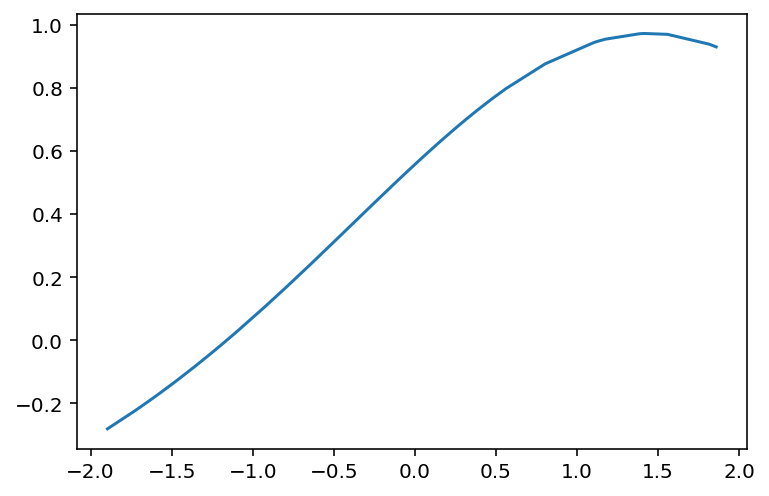

In [6]:
order = np.argsort(x.numpy()[:, 0])

plt.plot(x.numpy()[order], draw[order])

In [7]:
# Draw some data
probs = norm.cdf(draw)

In [8]:
y = tf.constant(np.random.binomial(1, probs), dtype=tf.float64)

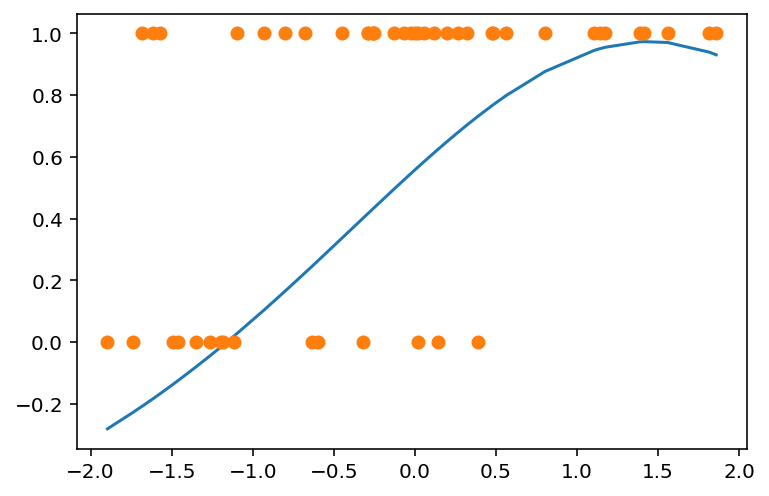

In [9]:
plt.plot(x.numpy()[order], draw[order])
plt.plot(x.numpy()[order], y.numpy()[order], marker='o', linestyle='none')

In [10]:
# Great. I have my input data x, and my outcomes y.

In [11]:
from ml_tools.lin_alg import num_triangular_elts

In [12]:
from ml_tools.lin_alg import num_triangular_elts

n_inducing = 10

m = tf.zeros(n_inducing, dtype=tf.float64)
n_elts = num_triangular_elts(n_inducing)
L_elts = tf.Variable(np.random.randn(n_elts))
indices = np.array(np.tril_indices(n_inducing)).T

L = tf.scatter_nd(indices, L_elts, (n_inducing, n_inducing))

In [13]:
Z = tf.constant(np.random.uniform(-2, 2, 10).reshape(-1, 1))
#Z = x

In [14]:
from svgp.tf.quadrature import expectation
from svgp.tf.likelihoods import bernoulli_probit_lik
from svgp.tf.svgp import (project_to_f, compute_qf_mean_cov, 
                          compute_kl_term, compute_objective, extract_params)
from functools import partial

In [15]:
kernel_fn = partial(ard_rbf_kernel, lengthscales=lscale, alpha=alpha)

In [16]:
mean, cov = compute_qf_mean_cov(L, m, x, Z, kernel_fn)

In [17]:
expectation(y, tf.diag_part(cov), mean, bernoulli_probit_lik)

W0918 15:22:59.053184 4451059136 deprecation.py:323] From /anaconda2/envs/jax/lib/python3.7/site-packages/tensorflow_probability/python/internal/special_math.py:154: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor: id=329, shape=(50,), dtype=float64, numpy=
array([ -1.68471011, -22.46916101,  -3.1358792 ,  -1.36265781,
        -2.26699189,  -1.29427984,  -2.17942381,  -3.65727733,
        -1.23949647,  -1.28245492,  -1.28815238,  -1.52041991,
        -3.6131031 ,  -1.5287481 ,  -1.66885998,  -1.15249657,
        -1.11339609,  -1.52167166,  -1.12202402,  -9.34981424,
        -1.52807823, -11.93792135,  -1.36791705,  -6.98327105,
        -4.10221033,  -1.36671416,  -1.09256124,  -5.82539882,
        -1.13944217,  -1.07535467,  -1.48164859,  -1.35499766,
        -1.22937443,  -1.50887767,  -1.52807545,  -1.21274519,
        -1.15530854,  -1.41774815,  -2.29651325,  -1.11857715,
        -2.79710674,  -1.52581048,  -1.12480101,  -1.04824902,
        -1.4526872 ,  -1.36591419,  -1.3969214 ,  -1.14770488,
        -1.51340378,  -2.27147729])>

In [18]:
compute_kl_term(m, L, Z, kernel_fn)

<tf.Tensor: id=402, shape=(), dtype=float64, numpy=1170083.376615265>

In [19]:
with tf.GradientTape() as tape:
    
    tape.watch(m)

    result = compute_objective(x, y, m, L, Z, bernoulli_probit_lik, kernel_fn)

In [20]:
grad = tape.gradient(result, m)

In [21]:
result

<tf.Tensor: id=746, shape=(), dtype=float64, numpy=-1170214.194444812>

In [22]:
grad

<tf.Tensor: id=1913, shape=(10,), dtype=float64, numpy=
array([  0.70106146,  -2.99397273,   6.28184925,   0.89313873,
         0.07643002,   7.237653  ,   5.12476676,   8.10753334,
       -14.26124682,   7.69071838])>

In [23]:
from ml_tools.lin_alg import num_triangular_elts

theta = tf.Variable(np.concatenate([
    np.random.randn(n_inducing),
    np.random.randn(num_triangular_elts(n_inducing)),
    np.reshape(1., (-1,)),
    np.reshape(3., (-1,))
]))

In [24]:
m, L, kern_params = extract_params(theta, n_inducing)

In [30]:
def rbf_bernoulli_objective(theta):
    
    m, L, kern_params = extract_params(
        theta, n_inducing, square_kern_params=True)
    
    kern_fn = partial(
        ard_rbf_kernel, alpha=kern_params[0],
        lengthscales=kern_params[1:], jitter=1e-6)
    
    cur_objective = -compute_objective(
        x, y, m, L, Z, bernoulli_probit_lik, kern_fn)
    
    return cur_objective

In [26]:
def to_optimize(theta):
    
    theta = tf.Variable(theta, dtype=tf.float64)
    
    with tf.GradientTape() as tape:
    
        tape.watch(theta)
        objective = rbf_bernoulli_objective(theta)
        
    grad = tape.gradient(objective, theta)
    
    print(objective)
        
    return objective.numpy(), grad.numpy()

In [27]:
start_theta = np.concatenate([
    np.random.randn(n_inducing),
    np.random.randn(num_triangular_elts(n_inducing)),
    np.reshape(1., (-1,)),
    np.reshape(3., (-1,))
])

In [28]:
from scipy.optimize import minimize

In [29]:
result = minimize(to_optimize, start_theta, jac=True)

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [ ]:
m, L, kern_params = extract_params(result.x, n_inducing)
L = L.numpy()

In [ ]:
order = np.argsort(x.numpy()[:, 0])
z_order = np.argsort(Z.numpy()[:, 0])

plt.plot(x.numpy()[order], draw[order])
plt.plot(Z.numpy()[z_order], m[z_order], marker='o')

In [ ]:
m

In [ ]:
import gpflow

In [ ]:
tf.disable_eager_execution()
gpflow.reset_default_graph_and_session()

kern = gpflow.kernels.RBF(input_dim=1, ARD=True)

In [ ]:
model = gpflow.models.SVGP(x.numpy(), y.numpy().reshape(-1, 1), kern, gpflow.likelihoods.Bernoulli(),
                           Z=Z.numpy(), whiten=False)

model.feature.set_trainable(False)

In [ ]:
opt = gpflow.train.ScipyOptimizer(options={'maxfun': int(1E6)})

In [ ]:
opt.minimize(model, maxiter=int(1E6))

In [ ]:
model

In [ ]:
q_mu_gpflow = model.as_pandas_table().loc['SVGP/q_mu'].value

In [ ]:
plt.scatter(q_mu_gpflow, m)
plt.plot([q_mu_gpflow.min(), q_mu_gpflow.max()], [q_mu_gpflow.min(), q_mu_gpflow.max()])

In [ ]:
q_sqrt_gpflow = model.as_pandas_table().loc['SVGP/q_sqrt'].value[0]

In [ ]:
q_sqrt_elts = q_sqrt_gpflow[np.tril_indices_from(q_sqrt_gpflow)]

In [ ]:
L_elts = L[np.tril_indices_from(L)]

In [ ]:
plt.scatter(q_sqrt_elts, L_elts)

In [ ]:
q_sqrt_diag = np.diag(q_sqrt_gpflow)

In [ ]:
l_diag = np.diag(L)

In [ ]:
my_cov = L @ L.T

In [ ]:
gpf_cov = q_sqrt_gpflow @ q_sqrt_gpflow.T

In [ ]:
np.diag(my_cov)

In [ ]:
np.diag(gpf_cov)

In [ ]:
plt.scatter(my_cov.reshape(-1), gpf_cov.reshape(-1))
plt.plot([my_cov.min(), my_cov.max()], [my_cov.min(), my_cov.max()])
plt.xlabel('My covariance')
plt.ylabel('GPFlow covariance')

In [ ]:
kern_params

In [ ]:
model

In [ ]:
kern_params[0]**2